In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D 
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.vgg16 import VGG16

%matplotlib inline

Using TensorFlow backend.


In [3]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
from utils.load_data import load_data
from utils.comparams import auc

W0516 20:16:29.180785 139744663658624 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/utils/comparams.py:1: The name tf.local_variables_initializer is deprecated. Please use tf.compat.v1.local_variables_initializer instead.



### Data Generator

In [4]:
data_dir = './data/macenko'

In [5]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', limit=None, val_limit=None, norm='macenko')
len(x_train), len(x_valid)

(261756, 32728)

In [6]:
x_train = x_train[:100000]
y_train = y_train[:100000]
x_valid = x_valid[:32000]
y_valid = y_valid[:32000]

In [7]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i):y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i):y_valid[i].flatten()[0] for i in val_id}

In [8]:
del train_id
del val_id
del data_dir

## MODEL

In [9]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

W0516 20:17:32.788746 139744663658624 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0516 20:17:32.801490 139744663658624 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0516 20:17:32.803641 139744663658624 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0516 20:17:32.820205 139744663658624 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_b

In [10]:
x = vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities

model = Model(inputs=vgg16.input, outputs=y)

# Train only the top layer
for layer in vgg16.layers:#[:-5]
    layer.trainable = False

model.summary()

### Compile

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000005)

In [14]:
optimizer = Adam(lr=0.001)#, beta_1=0.9, beta_2=0.999)
loss = 'categorical_crossentropy'
metrics = ['acc', auc]

In [15]:
model.compile(optimizer, loss, metrics)

## Train the model

In [16]:
# directory to save the best model
file_dir = './Model'
if not os.path.exists(file_dir):
    os.mkdir(file_dir)
    
model_name = 'vgg16_model_100K_stain_norm' #5layer_trainable
    
network_filepath = os.path.join(file_dir, model_name + '.h5')

In [17]:
# Define batch size.
batch_size = 128
n_epoch = 10
# time_limit = 500 # time limit in minute (500 -> 8 hrs and 20 min)

# Parameters for generators
params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **params)

#a function to save last_model compatible with the on_interrupt handler of TimerCallback
def saveWeights(model, elapsed):
    model.save_weights(os.path.join(file_dir, model_name + '_weights.h5'))


# Callbacks,
callbacks = [PlotCurves(), learning_rate_reduction]#, TimerCallback(1, on_interrupt=saveWeights)]
#roc_callback(training_data=training_generator,validation_data=validation_generator)

In [18]:
del x_train
del x_valid
del y_train
del y_valid
del train_labels
del val_labels

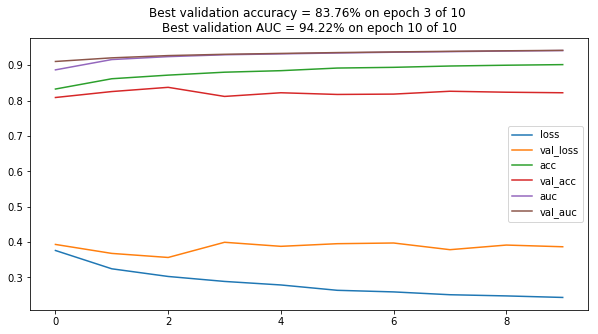

In [19]:
# Training with 10K again
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)

In [20]:
model.save(network_filepath)

### Runs

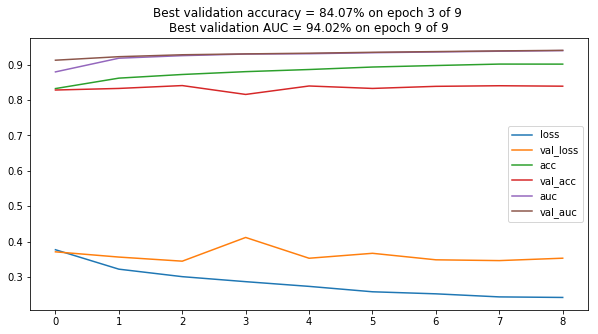


Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 10/10
389/390 [============================>.] - ETA: 0s - loss: 0.2374 - acc: 0.9042 - auc: 0.9408

In [ ]:
# Training with 50K 
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)

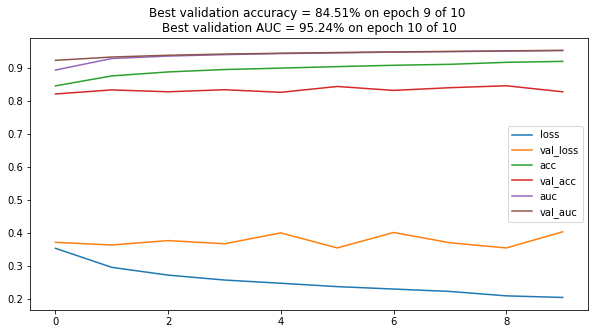

In [18]:
# Training with 100K 
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)

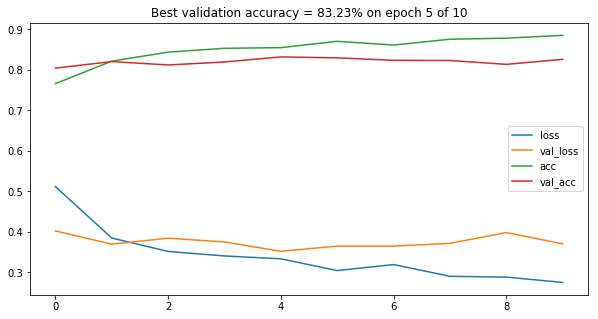

In [23]:
# Training with 10k
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)